# Results


## Librairies


In [2]:
import os
import pickle
import json

import pandas as pd
import numpy as np
import torch

from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import mean_squared_error

# from datasets import Dataset
from datasets import load_from_disk

from transformers import AutoTokenizer
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers.data.data_collator import DataCollatorWithPadding

from transformers.modeling_outputs import SequenceClassifierOutput

from rdkit import Chem # type: ignore

import matplotlib.pyplot as plt
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
# plt.style.use('ggplot')

from huggingface_hub import login

import torch.nn as nn

2024-08-27 08:55:08.574166: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 08:55:08.574286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 08:55:08.656678: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 08:55:08.826194: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-27 08:55:10.355323: W tensorflow/compiler/tf2

In [3]:
HF_TOKEN = "" #HuggingFace Login Token goes here
login(HF_TOKEN)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Preamble


In [4]:
# *** CHOSE YOUR MODE HERE: "comp" / "exp" / "comp2exp"***

suffix = "comp"

if suffix == "comp":
    test_size = 8551
elif suffix == "exp":
    test_size = 6000
elif suffix == "comp2exp":
    test_size = 6000

In [5]:
RESULTS_DIR = os.path.join("/storage/smiles2spec_models", suffix) #PATH of folder containing results files
RESULTS_DIR

'/storage/smiles2spec_models/comp'

In [6]:
model_names_original = [#"DeepChem/ChemBERTa-5M-MLM", 
                        "DeepChem/ChemBERTa-5M-MTR",
                        #"DeepChem/ChemBERTa-10M-MLM",
                        #"DeepChem/ChemBERTa-10M-MTR",
                        #"DeepChem/ChemBERTa-77M-MLM",
                        #"DeepChem/ChemBERTa-77M-MTR"
                        ]

In [7]:
model_names = [model.split("/")[1] for model in model_names_original]
model_names

['ChemBERTa-5M-MTR']

## Visualize some spectra


For `RDKit` basic functionalities, see https://xinhaoli74.github.io/posts/2020/04/RDKit-Cheatsheet/


In [8]:
# load test set

DATA_DIR = "/datasets" #PATH of test dataset

In [9]:
def plot_example(test_truths, test_preds, i, data_suffix, add_info="", filename=None):
    """Plot i-th item of (test_truths, test_preds)"""
    
    # get 2D-Mol graph
    test_dataset = load_from_disk(os.path.join(DATA_DIR, f"test_{data_suffix}"))
    smiles = test_dataset[int(i)]["smiles"]
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.Draw.MolToImage(mol)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 4))
        
    # true spectrum
    spectrum_truth = test_truths[i, :]
    #spectrum_truth = gaussian_filter1d(spectrum_truth, sigma=5) # Gaussian convolution # XXX apply or not???
    #spectrum_truth_sum = spectrum_truth.sum()                    # Normalization
    #spectrum_truth = spectrum_truth / spectrum_truth_sum
    
    # predicted spectrum
    spectrum_pred = test_preds[i, :]
    #spectrum_pred = gaussian_filter1d(spectrum_pred, sigma=5) # Gaussian convolution
    #spectrum_pred_sum = spectrum_pred.sum()                    # Normalization
    #spectrum_pred = spectrum_pred / spectrum_pred_sum
    
    xticks = 400 + 2*np.array(range(len(spectrum_truth)))
    plt.plot(xticks, spectrum_truth, label="true spectrum", alpha=1.0, linewidth=2)
    plt.plot(xticks, spectrum_pred, label=f"predicted spectrum{add_info}", alpha=0.6, linewidth=2)
    plt.title(smiles, size=12) # type: ignore
    
    # 2D-Mol graph
    x, y = 2500, spectrum_truth.max() / 1.5
    im = OffsetImage(mol, zoom=0.4, zorder=10)
    ab = AnnotationBbox(im, (x, y), frameon=False)
    ax.add_artist(ab)
    
    plt.xlabel("wavenumbers (cm$^{-1}$)")
    plt.xticks()
    plt.ylabel("absorbance (a.u.)")
    plt.legend()
    plt.title(f"Model trained on comp. Spectra, predictions on {data_suffix}.")

    if filename is not None:
        plt.savefig(f"/storage/results_{suffix}/{filename}")
    
    plt.show()

# Choose model

model = "ChemBERTa-5M-MTR"
data_suffix = "comp"
test_size = 8551 if data_suffix == "comp" else 6000

test*preds = torch.load(os.path.join(RESULTS_DIR, f'{model}/test_preds*{data*suffix}.pt'))
test_truths = torch.load(os.path.join(RESULTS_DIR, f'{model}/test_truths*{data_suffix}.pt'))

for i in np.random.choice(test_size, 5):

    plot_example(test_truths, test_preds, i, data_suffix)


**Remarks**

- Some predictions are below 0, which is impossible, therefore, we have to clip the test_preds!
- We did this in the code above...


## Losses


In [10]:
RESULTS_DIR

'/storage/smiles2spec_models/comp'

In [11]:
history_d = {}

for model in model_names:
    
    file = os.path.join(RESULTS_DIR, model, "log_history.pkl")
    
    with open(file, "rb") as fh:
        
        history_d[model] = pickle.load(fh)

In [12]:
losses_d = {}

for model in model_names:
        
    l_full = history_d[model]
    l_train = [d for d in l_full if "loss" in d.keys()]
    l_val = [d for d in l_full if "eval_loss" in d.keys()]

    train_loss = {d["step"] : d["loss"] for d in l_train}
    val_loss = {d["step"] : d["eval_loss"] for d in l_val}
    
    losses_d[model] = (train_loss, val_loss)

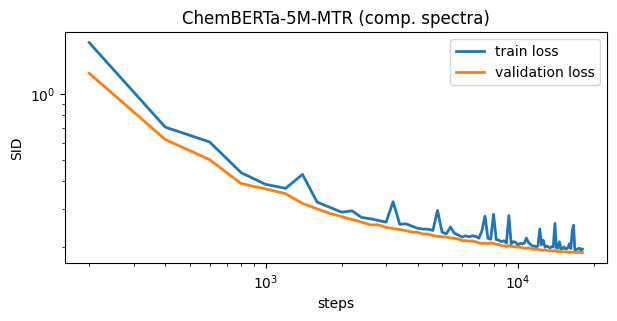

In [13]:
for model in model_names:

    train_loss, val_loss = losses_d[model]

    plt.figure(figsize=(7, 3))

    plt.plot(list(train_loss.keys()), list(train_loss.values()), label="train loss", linewidth=2)
    plt.plot(list(val_loss.keys()), list(val_loss.values()), label="validation loss", linewidth=2)

    plt.xlabel("steps")
    plt.ylabel("SID")
    plt.title(f"{model} ({suffix}. spectra)")

    plt.legend()
    plt.savefig(f"/storage/results_{suffix}/{model}_loss.png", bbox_inches='tight')

## Test predictions


In [14]:
HF_token = "" #HuggingFace login token goes here
RESULTS_DIR

'/storage/smiles2spec_models/comp'

In [15]:
# Load models, tokenizers and test sets, and compute test predictions
# takes some time and needs GPU...

metrics_d = {}
    
#model_dir_l = os.listdir(RESULTS_DIR)

for data_suffix in ["comp", "exp"]:
    
    metrics_d[data_suffix] = {}
    
    for model_name in model_names:
        
        metrics_d[data_suffix][model_name] = {}


        test_preds = torch.from_numpy(torch.load(os.path.join(RESULTS_DIR, model_name, f'test_preds_{data_suffix}.pt')))
        test_truths = torch.from_numpy(torch.load(os.path.join(RESULTS_DIR, model_name, f'test_truths_{data_suffix}.pt')))
       
        metrics_d[data_suffix][model_name]["test_preds"] = np.array(test_preds)
        metrics_d[data_suffix][model_name]["test_truths"] = np.array(test_truths)

## MSE, RMSE, TMSE, SID and SIS


### Metrics


In [16]:
def get_MSE(y, y_hat):
    """mean squared error (MSE)"""

    MSE = nn.MSELoss(reduction='none')    

    MSEs = torch.mean(MSE(y, y_hat), 1)

    std, mean = torch.std_mean(MSEs)
    
    return MSEs.numpy(), mean.item(), std.item()

In [17]:
def get_RMSE(y, y_hat):
    """root mean squared error (RMSE)"""

    MSE = nn.MSELoss(reduction='none')

    MSEs = torch.mean(MSE(y, y_hat), 1)
    
    RMSEs = torch.sqrt(MSEs)

    std, mean = torch.std_mean(RMSEs)
    
    return RMSEs.numpy(), mean.item(), std.item()

In [18]:
def get_TMSE(y, y_hat):
    """target-weighted mean squared error (TMSE)"""
    TMSEs = torch.mean(((y - y_hat)**2)/y, 1)

    std, mean = torch.std_mean(TMSEs)
    
    return TMSEs.numpy(), mean.item(), std.item()

In [19]:
class SIDLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, model_spectra, target_spectra):


        loss = torch.ones_like(target_spectra)

        loss = torch.mul(torch.log(torch.div(model_spectra, target_spectra)), model_spectra) \
                + torch.mul(torch.log(torch.div(target_spectra, model_spectra)), target_spectra)
        
        loss = torch.sum(loss, dim=1)

        return loss

def get_SIS(y, y_hat):
    """spectral information similarity (SIS)
    """
    
    #Gaussian Convolution
    y_hat_conv = gaussian_filter1d(y_hat, 5)
    y_conv = gaussian_filter1d(y, 5)

    #Normalization
    y_hat_conv = nn.functional.normalize(torch.tensor(y_hat_conv), p=1)
    y_conv = nn.functional.normalize(torch.tensor(y_conv), p=1)
    
    #Initialize SID Class
    SID = SIDLoss()
    
    SIDs = SID(y_hat_conv, y_conv)

    SISs = 1/(1+SIDs)

    std, mean = torch.std_mean(SISs)
    
    return SISs.numpy(), mean.item(), std.item()

def get_SID(y, y_hat):
    """spectral information divergence"""

    SID = SIDLoss()
    
    SIDs = SID(y_hat, y)

    std, mean = torch.std_mean(SIDs)

    return SIDs.numpy(), mean.item(), std.item()


In [20]:
# compute metrics

for data_suffix in ["comp", "exp"]:
        
    print(data_suffix)
    
    for model in model_names:

        print(model)

        y = torch.from_numpy(metrics_d[data_suffix][model]["test_truths"])
        y_hat = torch.from_numpy(metrics_d[data_suffix][model]["test_preds"])
        

        MSEs, MSE_mean, MSE_std = get_MSE(y, y_hat)
        metrics_d[data_suffix][model]["MSEs"] = MSEs
        metrics_d[data_suffix][model]["MSE"] = MSE_mean, MSE_std

        RMSEs, RMSE_mean, RMSE_std = get_RMSE(y, y_hat)
        metrics_d[data_suffix][model]["RMSEs"] = RMSEs
        metrics_d[data_suffix][model]["RMSE"] = RMSE_mean, RMSE_std

        TMSEs, TMSE_mean, TMSE_std = get_TMSE(y, y_hat)
        metrics_d[data_suffix][model]["TMSEs"] = TMSEs
        metrics_d[data_suffix][model]["TMSE"] = TMSE_mean, TMSE_std

        SIDs, SID_mean, SID_std = get_SID(y, y_hat)
        metrics_d[data_suffix][model]["SIDs"] = SIDs
        metrics_d[data_suffix][model]["SID"] = SID_mean, SID_std

        SISs, SIS_mean, SIS_std = get_SIS(y, y_hat)
        metrics_d[data_suffix][model]["SISs"] = SISs
        metrics_d[data_suffix][model]["SIS"] = SIS_mean, SIS_std

comp
ChemBERTa-5M-MTR
exp
ChemBERTa-5M-MTR


In [21]:
# compute and save metrics

metrics_comp_df = pd.DataFrame.from_dict(metrics_d["comp"], orient="index")
metrics_comp_df.to_csv(f"/storage/results_{suffix}/metrics_comp_testset.csv")

metrics_exp_df = pd.DataFrame.from_dict(metrics_d["exp"], orient="index")
metrics_exp_df.to_csv(f"/storage/results_{suffix}/metrics_exp_testset.csv")

In [22]:
metrics_comp_df

,test_preds,test_truths,MSEs,MSE,RMSEs,RMSE,TMSEs,TMSE,SIDs,SID,SISs,SIS
ChemBERTa-5M-MTR,"[[0.00055121863, 0.00054261094, 0.0005374244, ...","[[0.00065334636, 0.000657514, 0.00065663963, 0...","[1.6369893e-07, 4.1223245e-07, 4.963148e-08, 7...","(2.8822194053645944e-07, 9.056657290784642e-07)","[0.00040459723, 0.0006420533, 0.00022278124, 0...","(0.00046780018601566553, 0.0002634256088640541)","[0.00024352291, 0.0003787108, 8.885938e-05, 7....","(0.07367365807294846, 2.0895066261291504)","[0.15947631, 0.3218162, 0.09133448, 0.11963973...","(0.265326589345932, 0.38022416830062866)","[0.9283639, 0.8585256, 0.9509144, 0.9355835, 0...","(0.8927193880081177, 0.07025044411420822)"


In [23]:
metrics_exp_df

,test_preds,test_truths,MSEs,MSE,RMSEs,RMSE,TMSEs,TMSE,SIDs,SID,SISs,SIS
ChemBERTa-5M-MTR,"[[0.0008179901, 0.0008433614, 0.00079193024, 0...","[[0.00078641047, 0.00079038757, 0.00079060835,...","[5.7235656e-07, 1.610758e-07, 9.2572705e-08, 8...","(4.1314245891044266e-07, 1.2199460570627707e-06)","[0.0007565425, 0.0004013425, 0.00030425764, 0....","(0.0005612385575659573, 0.0003133210411760956)","[0.00038051265, 0.00029797162, 0.00012904167, ...","(0.07167097926139832, 1.3473563194274902)","[0.42334923, 0.2678941, 0.113996595, 0.0983364...","(0.35563045740127563, 0.43909209966659546)","[0.82624346, 0.87327635, 0.9423845, 0.94763094...","(0.8626538515090942, 0.07671196013689041)"


### Distributions


In [24]:
def plot_distribution(metrics, mean_std, metrics_name=None, model_name=None, data_suffix=None):
    """Plot distribution of a given metrics and save it as pdf"""
    
    mean, std = mean_std
    
    plt.figure(figsize=(4.5,3))
    plt.hist(metrics, bins=50, density=True, 
             edgecolor='black', 
             linewidth=0.5,
             color="C1",
             alpha=0.5,
             label=f"mean: {mean:.4f}\nstd: {std:.4f}")

    plt.xlabel(f"{metrics_name}")
    plt.legend()
    plt.title(f"{model_name}\n train: {suffix}. data, results: {data_suffix}. test set")
    plt.savefig(f"/storage/results_{suffix}/{model_name}_{metrics_name}_{data_suffix}_testset.png", bbox_inches='tight')

try: # does not work for comp2exp
metrics = metrics_d[suffix]["ChemBERTa-5M-MTR"]["SISs"]
mean_std = metrics_d[suffix]["ChemBERTa-5M-MTR"]["SIS"]
metrics_name = "SIS"
model_name = "ChemBERTa-5M-MTR"
plot_distribution(metrics, mean_std, metrics_name, model_name, data_suffix)

except:
pass


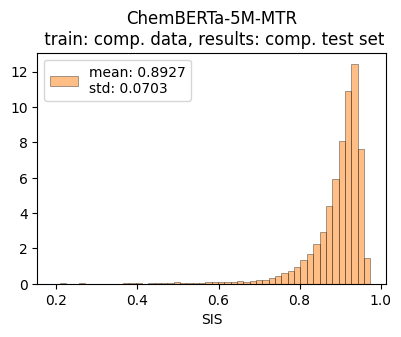

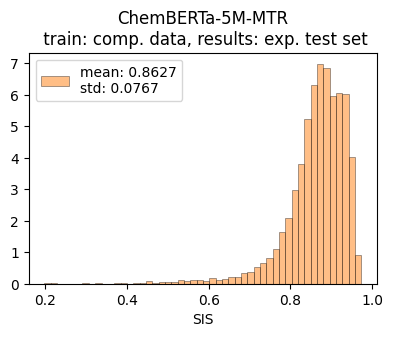

In [25]:
for data_suffix in ["comp", "exp"]:

    for model_name, values in metrics_d[data_suffix].items():

        # for metrics_name in ["MSE", "RMSE", "TMSE", "SID", "SIS"]:
        for metrics_name in ["SIS"]:

            metrics = metrics_d[data_suffix][model_name][metrics_name+"s"]
            mean_std = metrics_d[data_suffix][model_name][metrics_name]

            plot_distribution(metrics=metrics, 
                              mean_std=mean_std, 
                              metrics_name=metrics_name, 
                              model_name=model_name,
                              data_suffix=data_suffix)

## Examples based on percentiles


ChemBERTa-5M-MTR comp
example in percentile 10


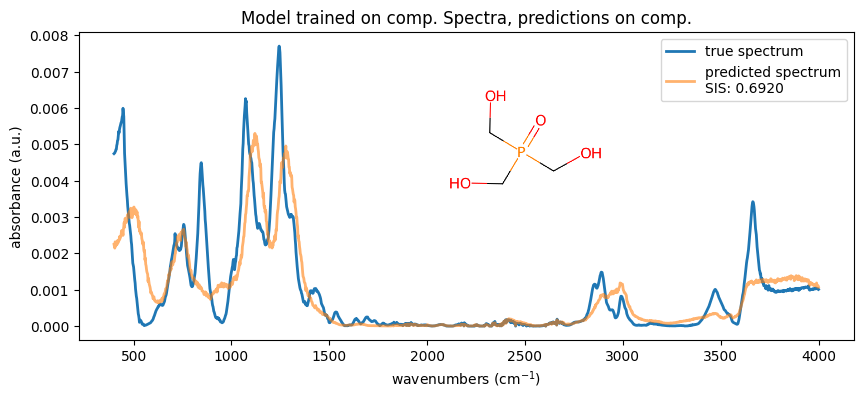

example in percentile 20


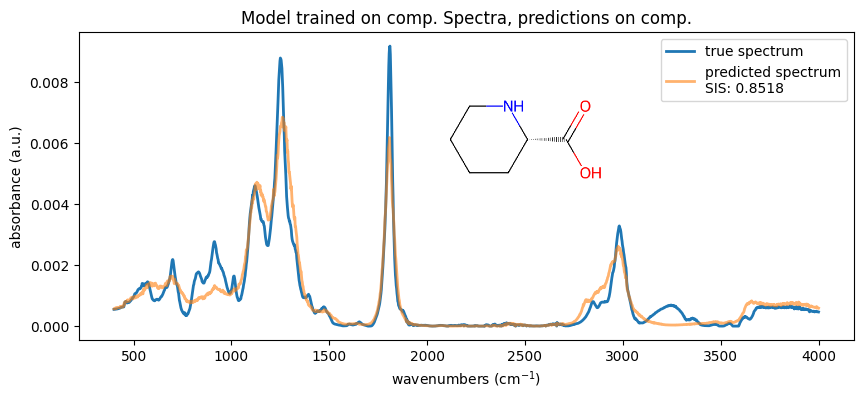

example in percentile 30


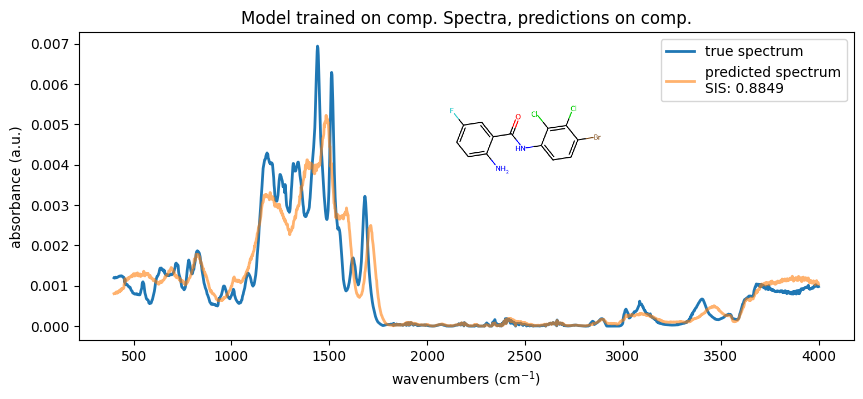

example in percentile 40


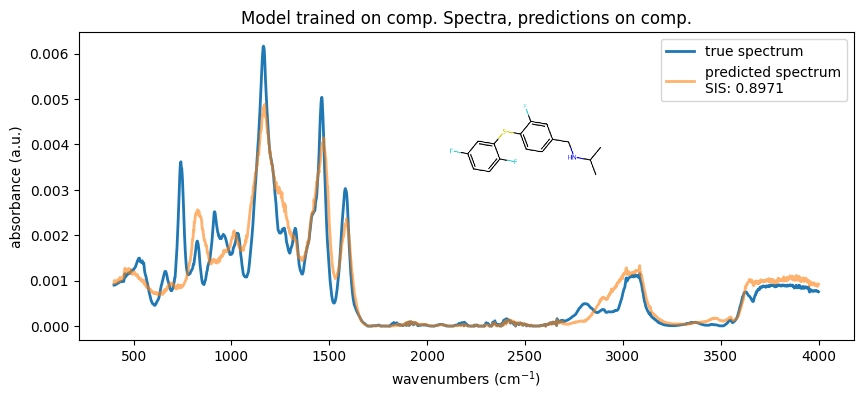

example in percentile 50


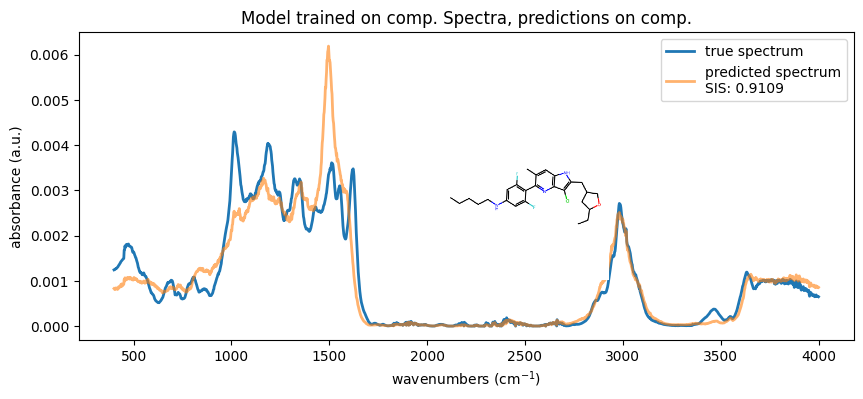

example in percentile 60


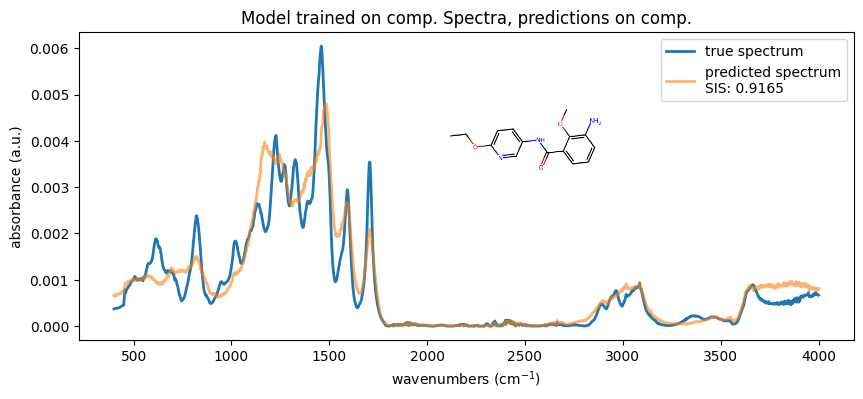

example in percentile 70


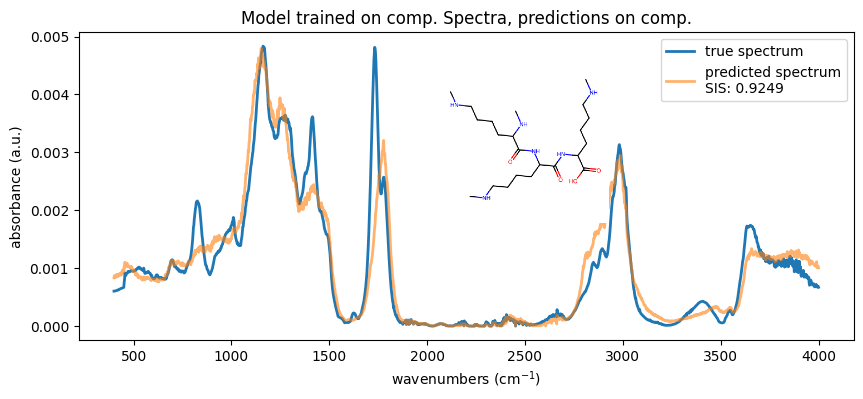

example in percentile 80


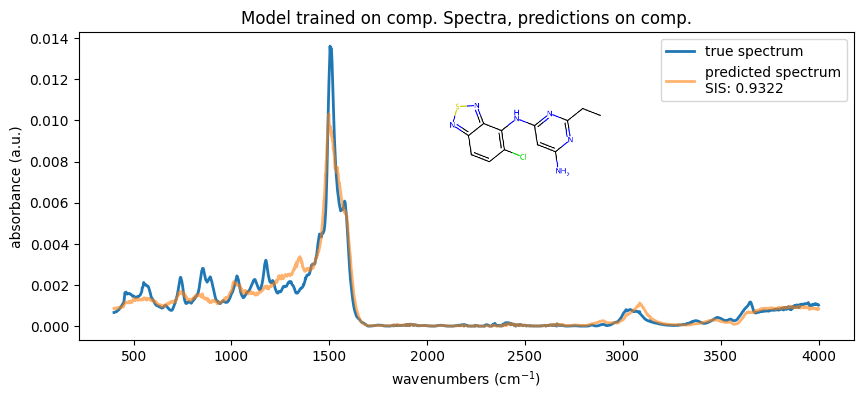

example in percentile 90


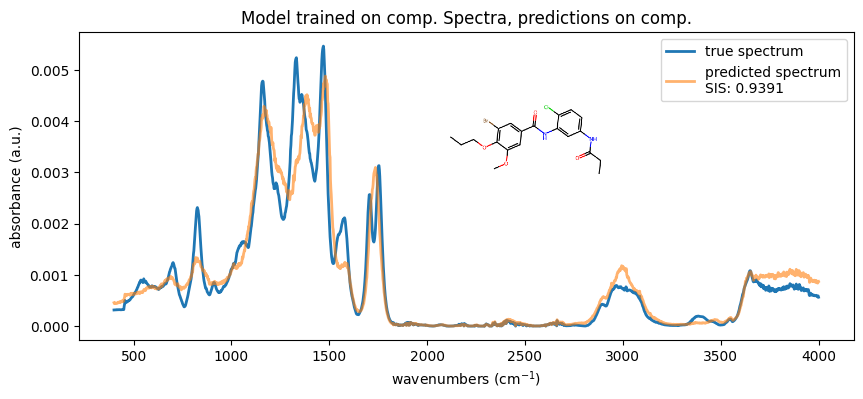

ChemBERTa-5M-MTR exp
example in percentile 10


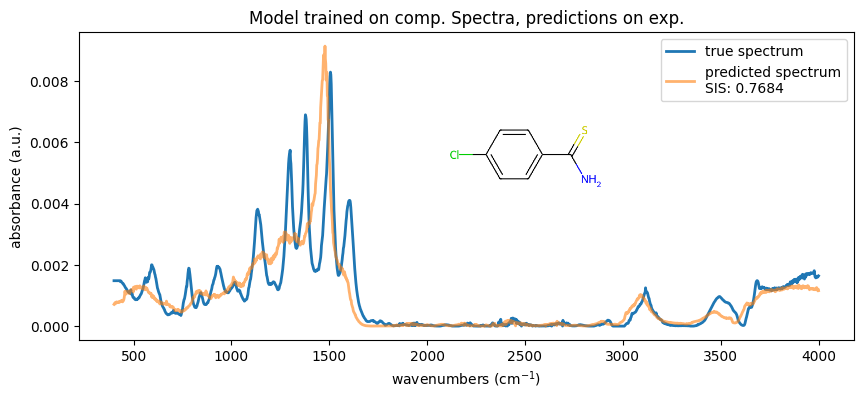

example in percentile 20


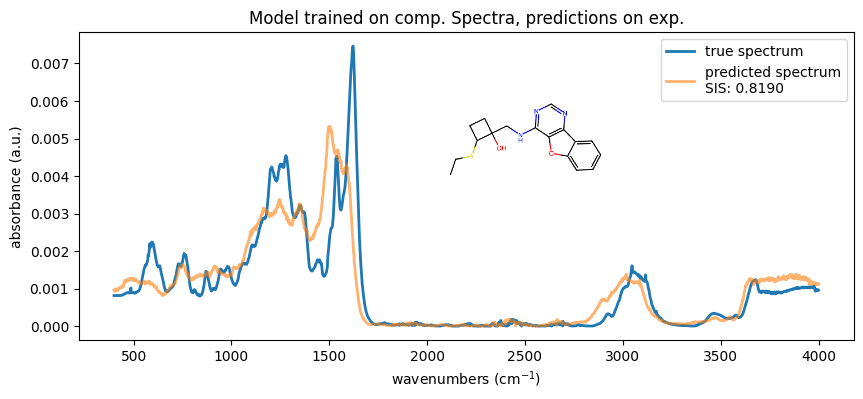

example in percentile 30


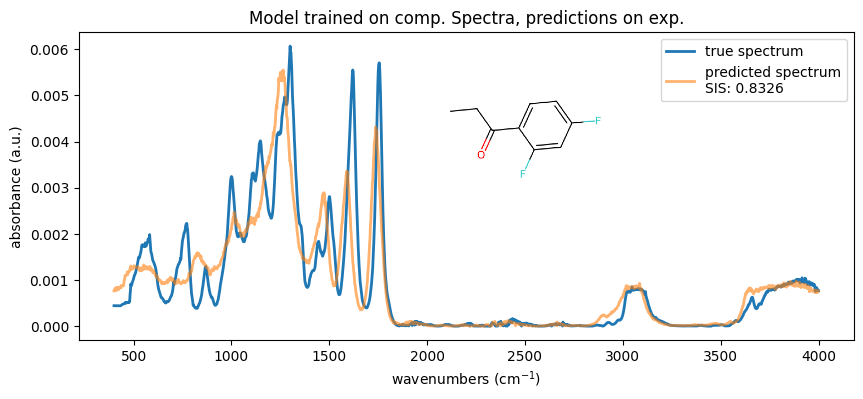

example in percentile 40


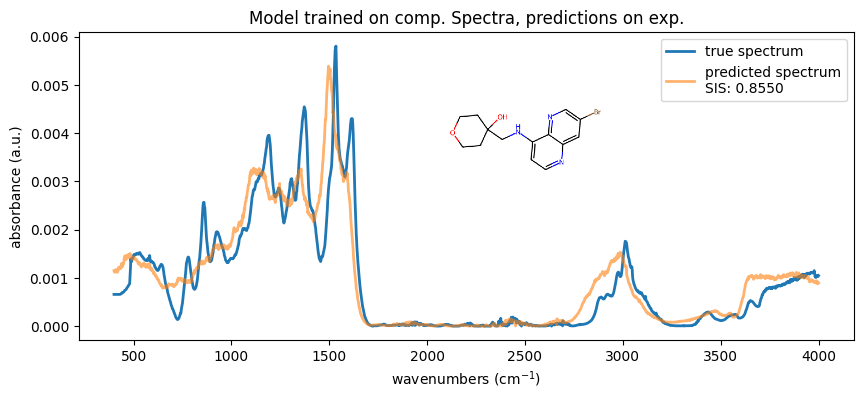

example in percentile 50


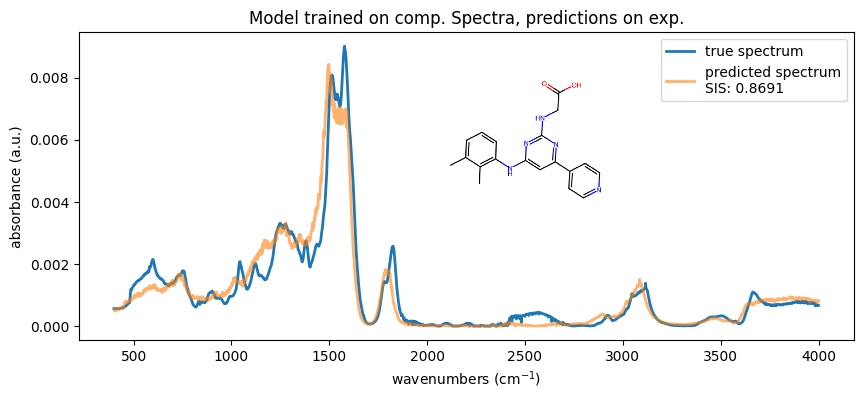

example in percentile 60


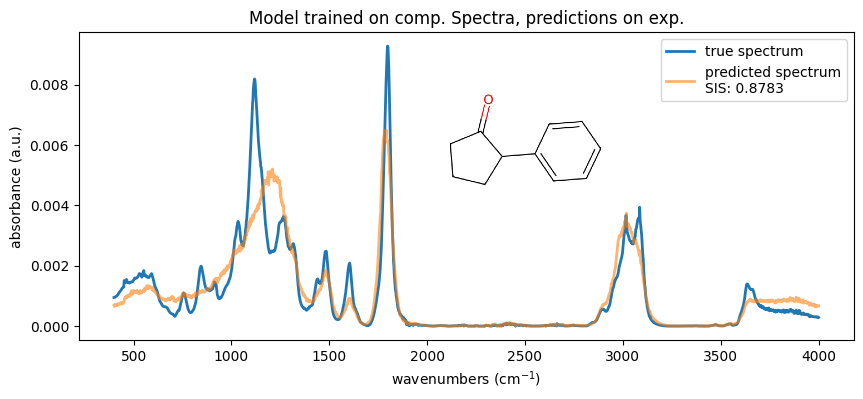

example in percentile 70


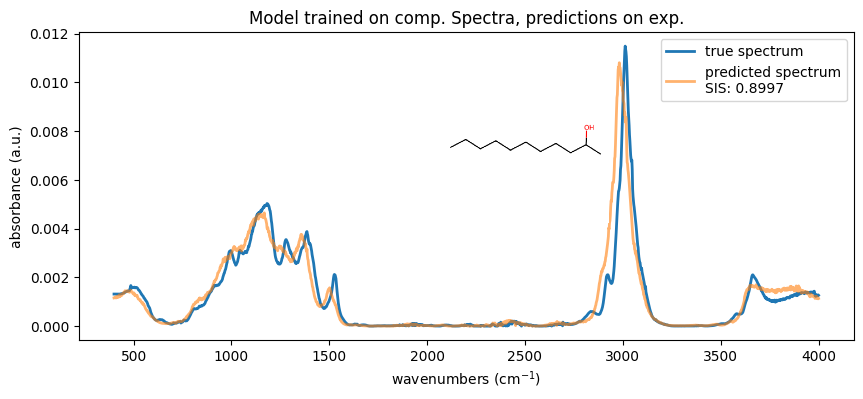

example in percentile 80


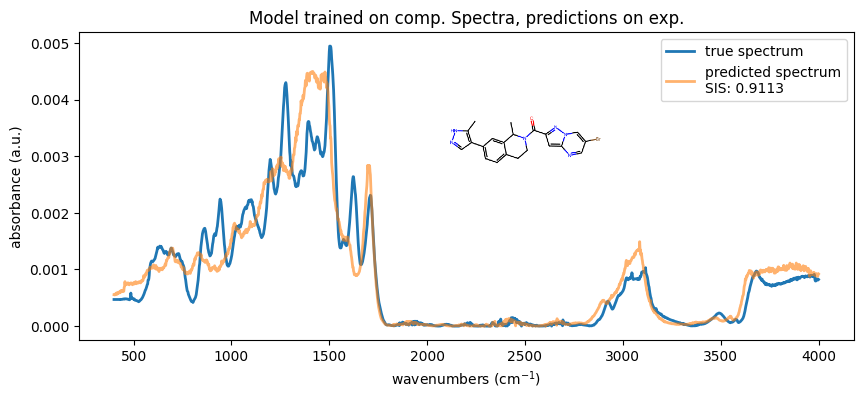

example in percentile 90


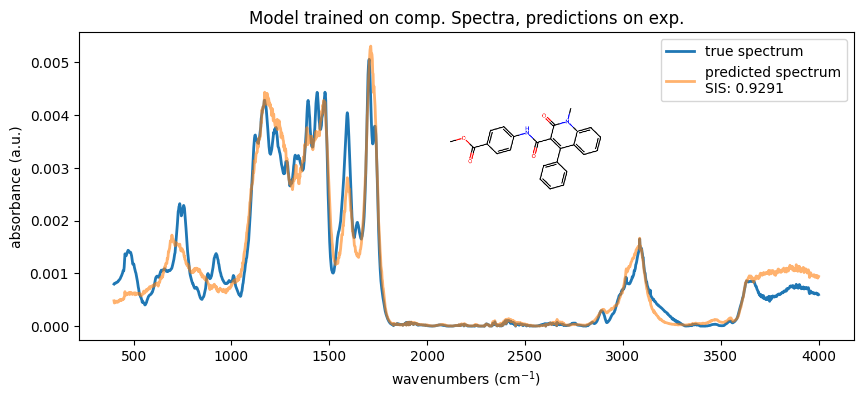

In [26]:
#TODO: parameters Raw/Convolutionned pour affichage

if suffix != "comp2exp":
    data_suffix = suffix # examples for x data if model has been trained on x data
else:
    data_suffix = "comp"

for data_suffix in ["comp", "exp"]:
    for model_name, values in metrics_d[data_suffix].items():

        print(model_name, data_suffix)

        test_truths = metrics_d[data_suffix][model_name]["test_truths"]
        test_preds = metrics_d[data_suffix][model_name]["test_preds"]

        SISs = metrics_d[data_suffix][model_name]["SISs"]
        percentiles = []

        for p in range(10, 100, 10):
            percentiles.append(np.percentile(SISs, p))

        lb = 0

        for i in range(len(percentiles)): 

            # get percentile
            ub = percentiles[i]
            mask = (SISs >= lb) & (SISs <= ub)
            lb = percentiles[i]

            # plot example from percentile 
            indices = np.where(mask==True)[0]
            index = np.random.choice(indices, size=1)[0]

            p = i*10 + 10
            print(f"example in percentile {p}")
            filename = f"{model_name}_{data_suffix}_percentile_{p}.png"
            add_info = f"\nSIS: {SISs[index]:.4f}"
            plot_example(test_truths, test_preds, index, data_suffix, add_info, filename)